# Mutual Fund Classification on Spark (February 2022)

## Introduction

The COVID-19 pandemic has brought about many changes in people's habits, including an increase in the number of young people who have started investing their excess savings or stimulus money received from governments. According to a survey conducted by brokerage firm Charles Schwab, 15% of respondents started investing in 2020. Some of these investors have gained attention in the news for their involvement in the GameStop short squeeze earlier in 2021. As the pandemic and its restrictions begin to ease, central banks are indicating the end of their accommodative policies due to the risk of persistent inflation. This may signal the end of "easy money" for retail investors and the need to create diversified portfolios to face uncertainties.

In this coursework, we aim to explore how distributed computing can be used to enhance investment decisions. Mutual funds, which are investment vehicles managed by a fund manager to generate returns for shareholders, often involve fees. With a vast number of funds available (our file contains 23,783 funds!), it can be challenging for non-professional investors to build a portfolio, as there are numerous choices to compare with different performance metrics, and many funds that overlap in their stated categories or investment policies.

### Dataset 

https://www.kaggle.com/datasets/stefanoleone992/mutual-funds-and-etfs?select=MutualFund+prices+-+F-K.csv

Dataset is stored in **hdfs:///user/etan001/CW2/MutualFunds.csv**

We searched Kaggle for a dataset relevant to our background in finance and found the "US Funds dataset from Yahoo Finance" by Stefano Leone. This dataset contains various prices and metrics for over 23,000 US-based funds and ETFs scraped from Yahoo Finance. The data was collected between 2011 and November 2021 and was last updated on December 11th, 2021.

Our dataset consists of 7 files with a total size of 2.07 GB.

Here is a non-comprehensive list of some investing terms that we will be using in this coursework, as defined by investopedia:

- Net expense ratio : refers to the cost of being invested in a mutual fund, it mostly comprise of management fees. One should take this into account when assessing how profitable a mutual fund can be.

- Alpha: also known as excess return, this additional return generated by a portfolio as compared to the overall market or benchmark. If alpha > 1 the portfolio outperforming the market/benchmark.

- Beta: also known as systematik risk, this measures the volatility of a portfilio compared to the overall market. If beta > 1 the portfolio is more volatile than the market.

- Sharpe ratio: measures the average return of a portfolio compared to the risk-free return. It is defined as the difference between the return of the investment and the risk-free rate, divided by the portfolio's standard deviation.

- Treynor ratio: measures how much excess return (compared to a risk-free return) was generated for each unit of risk taken, where the risk is measured by the portfolio's beta. 


When working on this topic, the first idea that comes to mind is making predictions on asset prices. However, there are many factors that can impact asset prices, some of which are outside the financial realm (such as the Covid-19 crisis or geopolitical tensions). Considering these factors can be challenging, and a simple linear regression is unlikely to provide meaningful insights to discuss.

### Hypotheses & Problem

At a high level, mutual funds are typically categorized based on their investment type, which is usually abbreviated to three categories: value, growth, or blend. Value investing involves comparing assets to each other and their intrinsic values to identify undervalued assets. Growth investing focuses on assets with high growth potential, regardless of perceived value. Blend funds are a combination of both approaches.

At a lower level, mutual funds can also be classified based on their asset class (such as bonds or equities), universe (such as corporate or sovereign), industry (such as technology), or region.

The key takeaway is that mutual funds are categorized based on their investment objectives rather than their performance or affordability.

It is important to note that active mutual fund managers are typically compensated based on their performance relative to a benchmark index and their ranking. However, this can lead to negative consequences, such as managers taking on more risk than stated in their policy to outperform the index and achieve higher rankings (as seen in the H2O Asset Management scandal). On the other hand, fund managers may be incentivized to simply follow the index and barely beat it, resulting in the fund outperforming its index but investors still losing money after accounting for fund expenses.

This illustrates that a lack of understanding regarding the risk-return pattern can result in inefficient investment decisions and performance that falls short of expectations. Therefore, improved classification based on fund performance, costs, and structure is necessary.

This is particularly pertinent given that empirical evidence of historical returns of active mutual funds compared to their benchmarks has indicated that less than 10% are able to produce excess returns (alpha) over a ten-year time frame. This percentage is further reduced once taxes and fees are factored in.

The hypotheses of this coursework focus on the notion that fund classification is suboptimal, with many funds being misclassified for the following reasons:

- **Limited number of investment types**: We believe that simply categorizing funds as value or growth is not informative enough, especially when the majority of funds end up being classified as blend.

- **Overcategorization**: There are too many categories that may not always be relevant (such as Target Date Retirement and Children's Education funds, which are simply marketing names for hybrid funds invested in equities and bonds) or are repetitive (such as Muni California Long and Muni New York, which are both municipal bonds).

- **Voluntary misclassifications to improve a fund's rating or trading volume**: For example, Investment Grade Bond Funds that invest in lower-rated (riskier) bonds than implied by their name.

Our objective is to determine whether we can efficiently select mutual funds based on cost and performance metrics. To achieve this, we are using cluster analysis to categorize mutual funds based on various metrics, including fund size, expense ratio, risk, trading volume/liquidity, and investment performance ratios.

The resulting clusters should exhibit similar performances (measured by returns, risk-adjusted return, etc.) as well as similar costs (measured by net expense ratio).

### Planned Analysis

Now that we have a better view of our dataset content, we need to decide on the relevant features that we will take to implement K Means Clustering.
An important consideration is to avoid overfitting, and some of these features are indeed similar (for example sharpe ratio is alrady based on standard deviation) 


We will first explore the dataset, which features can split into several categories :
- fund general information (e.g. Asset under Management, Investment Style, Fee, ...)
- portfolio component (cash, bond, stock and sectors % allocation)
- returns metrics( Year to date, 3Y, 5Y, ...) 
- financial ratios (as price/earning, Treynor and Sharpe ratios, alpha, beta, ...)
- esg (environmental, social, and governance) score metrics

Once we have a better understanding of our dataset we will pick relevant features that we will use to implement K-Means Clustering algorithm on.
If the clusters are not informative, we proceed to adjustments on the variables, whether by replacing or adding new features until the algorithm results in informative clusters.
We then proceed to analyze these clusters to see how a portfolio can be built based on these.

Because we are dealing with a large dataset under the Spark distributed computing framework, there are some points to consider:
- avoiding the use of for loop: as big data files take a long time to process, it is usually advised not to use loop operations. For simple computations it is advised to use Dataframe select() or withColumn() functions and take advantage of SQL functions.
- filter as much as possible : for the same reason, it is advised to filter the dataset as much as possible so that we display only what is needed.

Of course, the dataset we are using in this coursework is far smaller than a real big dataset, so we could technically ignore all these points and still manage to run our operations but we will try to practice it with real Big Data considerations.

## Project Implementation

### Technology used and accessing the dataset

To undertake this project, we are utilizing Apache Spark, which is described by its creators as a "unified analytics engine for large-scale data processing." Apache Spark processes large datasets by distributing them across multiple clusters (as opposed to scaling up a single machine).

We are programming in Python using the Pyspark interface, which allows us to access Spark APIs natively running on Scala. Although Spark is built around RDDs, we are primarily using Spark Dataframes at a high level, as they are more user-friendly and offer greater flexibility.

We downloaded our dataset using Kaggle API (installation required).
Then we unzipped the files and renamed them conveniently.
Once done the next step is to store the dataset on hadoop file system using the put (copyFromLocal works as well) function.
Commented below are the instructions for setting up the dataset and save it in HDFS:

In [1]:
# pip install kaggle

# create a directory
# mkdir ~/.kaggle

# copy 'kaggle.json' file to the directory
# ! cp kaggle.json ~/.kaggle/

# Set permission for the file
# ! chmod 600 ~/.kaggle/kaggle.json

# This line downloads the dataset from kagglet :
# kaggle datasets download stefanoleone992/mutual-funds-and-etfs

# unzip the file
#unzip mutual-funds-and-etfs.zip

# This line will put every file from the current local directory to hdfs CW2 directory
#hdfs dfs -put -f * ./CW2

In [2]:
# Setting up the environment variables to launch spark
import os
os.environ["JAVA_HOME"] =  "/usr/lib/jvm/default-java"
os.environ["SPARK_HOME"] = "/opt/spark/current"

# We are using the findspark package to run pyspark on Jupyter Notebooks
import findspark
from pyspark.sql import SparkSession
findspark.init(spark_home='/opt/spark/current')

# Additional package we are importing to enables SQL based functions for EDA
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Creating Spark Context
spark = SparkSession.builder.appName('MF').master('yarn').getOrCreate()

In [4]:
# Reading the dataset
dataset = spark.read.csv('./CW2/MutualFunds.csv',header=True,escape='"',inferSchema=True)

### Exploratory Data Analysis

In [5]:
dataset.printSchema()
print((dataset.count(), len(dataset.columns)))

root
 |-- fund_symbol: string (nullable = true)
 |-- quote_type: string (nullable = true)
 |-- region: string (nullable = true)
 |-- fund_short_name: string (nullable = true)
 |-- fund_long_name: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- initial_investment: long (nullable = true)
 |-- subsequent_investment: integer (nullable = true)
 |-- fund_category: string (nullable = true)
 |-- fund_family: string (nullable = true)
 |-- exchange_code: string (nullable = true)
 |-- exchange_name: string (nullable = true)
 |-- exchange_timezone: string (nullable = true)
 |-- management_name: string (nullable = true)
 |-- management_bio: string (nullable = true)
 |-- management_start_date: string (nullable = true)
 |-- total_net_assets: long (nullable = true)
 |-- year_to_date_return: double (nullable = true)
 |-- day50_moving_average: double (nullable = true)
 |-- day200_moving_average: double (nullable = true)
 |-- week52_high_low_change: double (nullable = true)
 |-- wee

(23783, 298)


Our dataset contains 23783 funds and 298 features.
As for most kaggle datasets it was made to be ready for use, as we can see columns names are properly denominated, there is no need for data cleaning at this point.

Given the large number of features, after reviewing it we put them into callable lists

In [6]:
FUND_COST = ['total_net_assets','fund_yield','fund_annual_report_net_expense_ratio','fund_prospectus_net_expense_ratio']

FUND_ASSET_MIX = ['asset_cash','asset_stocks','asset_bonds','asset_others','asset_preferred','asset_convertible']

FUND_RATING = ['morningstar_overall_rating','morningstar_return_rating','morningstar_risk_rating']

FUND_PERF_METRICS = ['fund_alpha_3years',
'fund_beta_3years',
'fund_mean_annual_return_3years',
'fund_r_squared_3years',
'fund_stdev_3years',
'fund_sharpe_ratio_3years',
'fund_treynor_ratio_3years',
'fund_alpha_5years',
'fund_beta_5years',
'fund_mean_annual_return_5years',
'fund_r_squared_5years',
'fund_stdev_5years',
'fund_sharpe_ratio_5years',
'fund_treynor_ratio_5years',
'fund_alpha_10years',
'fund_beta_10years',
'fund_mean_annual_return_10years',
'fund_r_squared_10years',
'fund_stdev_10years',
'fund_sharpe_ratio_10years']

INDUSTRY = ['fund_sector_basic_materials',
'fund_sector_communication_services',
'fund_sector_consumer_cyclical',
'fund_sector_consumer_defensive',
'fund_sector_energy',
'fund_sector_financial_services',
'fund_sector_healthcare',
'fund_sector_industrials',
'fund_sector_real_estate',
'fund_sector_technology',
'fund_sector_utilities']

FUND_VS_BENCHMARK = [
    'fund_symbol',
    'fund_category',
    'fund_return_2020',
 'category_return_2020',
 'fund_return_2019',
 'category_return_2019',
 'fund_return_2018',
 'category_return_2018',
 'fund_return_2017',
 'category_return_2017',
 'fund_return_2016',
 'category_return_2016',
 'fund_return_2015',
 'category_return_2015',
 'fund_return_2014',
 'category_return_2014',
 'fund_return_2013',
 'category_return_2013',
 'fund_return_2012',
 'category_return_2012',
 'fund_return_2011',
 'category_return_2011',
 'fund_return_2010',
 'category_return_2010',
 'fund_return_2009',
 'category_return_2009',
 'fund_return_2008',
 'category_return_2008',
 'fund_return_2007',
 'category_return_2007',
 'fund_return_2006',
 'category_return_2006',
 'fund_return_2005',
 'category_return_2005',
 'fund_return_2004',
 'category_return_2004',
 'fund_return_2003',
 'category_return_2003',
 'fund_return_2002',
 'category_return_2002',
 'fund_return_2001',
 'category_return_2001',
 'fund_return_2000',
 'category_return_2000']

#### Fund General Information:
    

In [7]:
dataset.select('fund_symbol','fund_category','total_net_assets').orderBy('total_net_assets', ascending=False).show(10)

+-----------+--------------------+----------------+
|fund_symbol|       fund_category|total_net_assets|
+-----------+--------------------+----------------+
|      VFINX|         Large Blend|    753409982464|
|      VFIAX|         Large Blend|    753409982464|
|      VFFSX|         Large Blend|    753409982464|
|      VTISX| Foreign Large Blend|    404728872960|
|      VTIAX| Foreign Large Blend|    404728872960|
|      VTPSX| Foreign Large Blend|    404728872960|
|      VTSNX| Foreign Large Blend|    404728872960|
|      VGTSX| Foreign Large Blend|    404728872960|
|      FXAIX|         Large Blend|    343338287104|
|      VBMPX|Intermediate Core...|    312150884352|
+-----------+--------------------+----------------+
only showing top 10 rows



Note: While exploring our dataset we quickly noticed there was an issue with a couple of columns, namely :
fund_long_name, 
fund_short_name,
fund_family (the asset management firm managing the fund)
investment_strategy (a description of the fund)

For a significant portion of the datatset these four variables would not match the other features of the dataset meaning they refer to a different fund. For example the largest mutual funds by AUM is the Vanguard 500 Index Fund (ticker: VFFSX) which in this dataset points to a different fund name and family. A possible explanation is that yahoo finance code source was updated and that the webscrapping algorithm used by the dataset creator was not updated accordingly.
This issue does not compromise the exploitability of this dataset, as all other features (performance metrics, ratios, ...) seem accurate as we checked directly from the source. 

In [8]:
# VFXX (Vanguard 500 Index Fund) wrongly points out to Dimensional 2065 Target Date Re. However all other features (return, size, standard deviation ,...) match VFFSX. 
dataset.where(col('fund_symbol')=='VFFSX').select('fund_symbol','fund_long_name','fund_short_name','fund_family').show(vertical=True,truncate=False)
dataset.where(col('fund_symbol')=='DRILX').select('fund_symbol','fund_long_name','fund_short_name','fund_family').show(vertical=True,truncate=False)
dataset.where(col('fund_symbol')=='VGTSX').select('fund_symbol','fund_long_name','fund_short_name','fund_family').show(vertical=True,truncate=False)

-RECORD 0----------------------------------------------------------------------------------
 fund_symbol     | VFFSX                                                                   
 fund_long_name  | Dimensional 2065 Target Date Retirement Income Fund Institutional Class 
 fund_short_name | Dimensional 2065 Target Date Re                                         
 fund_family     | Dimensional Fund Advisors                                               

-RECORD 0----------------------------------------------------------------------------------
 fund_symbol     | DRILX                                                                   
 fund_long_name  | Dimensional 2060 Target Date Retirement Income Fund Institutional Class 
 fund_short_name | Dimensional 2060 Target Date Re                                         
 fund_family     | Dimensional Fund Advisors                                               

-RECORD 0----------------------------------------------------------------
 fun

In [9]:
# checking investment types
dataset.groupBy('investment_type').count().show()

+---------------+-----+
|investment_type|count|
+---------------+-----+
|           null| 1109|
|          Value| 6847|
|         Growth| 4925|
|          Blend|10902|
+---------------+-----+



In [10]:
# checking the content unlabelled investment type (null) and value
dataset.filter(col("investment_type").isNull()).groupBy('fund_category').count().sort(col('count').desc()).show(truncate=False)
dataset.filter(col("investment_type")=="Value").groupBy('fund_category').count().sort(col('count').desc()).show(10,truncate=False)

+------------------------------------+-----+
|fund_category                       |count|
+------------------------------------+-----+
|High Yield Bond                     |72   |
|Commodities Broad Basket            |62   |
|Intermediate Core-Plus Bond         |60   |
|Trading--Inverse Equity             |54   |
|Emerging Markets Bond               |51   |
|Nontraditional Bond                 |51   |
|Intermediate Core Bond              |51   |
|Short-Term Bond                     |43   |
|Multisector Bond                    |39   |
|Muni National Interm                |35   |
|Ultrashort Bond                     |30   |
|World Bond                          |28   |
|Emerging-Markets Local-Currency Bond|24   |
|Muni National Short                 |23   |
|Systematic Trend                    |23   |
|Muni Single State Interm            |20   |
|Inflation-Protected Bond            |20   |
|Convertibles                        |19   |
|Corporate Bond                      |19   |
|Short Gov

It seems most unlabelled funds are bond funds, while some indeed would not really fit any of the 3 generic investments types (e.g. commodities broad basket or short-term bonds) some could actually fit into it (470 high yield bond funds belong in Value type).

In [11]:
dataset.select('fund_category').distinct().count()

120

In [12]:
dataset.groupBy('fund_category').count().sort(col("count").desc()).show(15, truncate=False)

+-----------------------------+-----+
|fund_category                |count|
+-----------------------------+-----+
|Large Blend                  |1235 |
|Large Growth                 |1172 |
|Large Value                  |1080 |
|Diversified Emerging Mkts    |741  |
|Foreign Large Blend          |680  |
|null                         |663  |
|Allocation--50% to 70% Equity|658  |
|High Yield Bond              |629  |
|Small Blend                  |579  |
|Small Growth                 |578  |
|Short-Term Bond              |570  |
|Intermediate Core-Plus Bond  |566  |
|Mid-Cap Growth               |562  |
|Allocation--30% to 50% Equity|491  |
|World Allocation             |448  |
+-----------------------------+-----+
only showing top 15 rows



Funds in this dataset are divided into 120 types of categories, with a majority being Large Cap from Growth, Value or a mix of both.

#### Returns & Performance metrics

In [13]:
for x in FUND_PERF_METRICS:
    dataset.select(x).summary().show()

+-------+-------------------+
|summary|  fund_alpha_3years|
+-------+-------------------+
|  count|              22039|
|   mean|-1.0627573846363234|
| stddev| 5.1845348396439555|
|    min|             -50.73|
|    25%|              -2.79|
|    50%|              -0.47|
|    75%|               1.27|
|    max|              28.14|
+-------+-------------------+

+-------+------------------+
|summary|  fund_beta_3years|
+-------+------------------+
|  count|             22082|
|   mean|0.9686337288289142|
| stddev|0.4675800156533565|
|    min|             -21.8|
|    25%|              0.81|
|    50%|              1.01|
|    75%|              1.17|
|    max|              4.91|
+-------+------------------+

+-------+------------------------------+
|summary|fund_mean_annual_return_3years|
+-------+------------------------------+
|  count|                         22085|
|   mean|             0.937235227529993|
| stddev|            0.5914859144440677|
|    min|                         -5.21|
|  

We can see that the average mutual fund has an alpha of -1.06, meaning on average a mutual fund trails its benchmark by 1.6%. As there are various benchmarks and and various types of mutual funds this number does not give lot of insights but we can see that overall mutual funds tend have underperformed over the past 3 years.

In [14]:
dataset.groupBy('fund_category').agg(F.count(F.col('fund_category')), 
                                 F.avg(F.col('fund_alpha_3years')),
                                F.avg(F.col('fund_beta_3years')),
                                 F.avg(F.col('fund_mean_annual_return_3years')),
                                F.avg(F.col('fund_mean_annual_return_10years'))
                                ).where(F.col('count(fund_category)') >= 20).sort(col('avg(fund_alpha_3years)').desc()).show(truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------
 fund_category                        | Technology                
 count(fund_category)                 | 175                       
 avg(fund_alpha_3years)               | 10.43666666666667         
 avg(fund_beta_3years)                | 1.109119496855346         
 avg(fund_mean_annual_return_3years)  | 2.269748427672955         
 avg(fund_mean_annual_return_10years) | 1.5910457516339866        
-RECORD 1---------------------------------------------------------
 fund_category                        | Equity Precious Metals    
 count(fund_category)                 | 54                        
 avg(fund_alpha_3years)               | 8.502222222222223         
 avg(fund_beta_3years)                | 0.8268518518518518        
 avg(fund_mean_annual_return_3years)  | 1.7803703703703704        
 avg(fund_mean_annual_return_10years) | 0.18615384615384614       
-RECORD 2-----------------------------------------------------

In [15]:
dataset.groupBy('fund_category').agg(F.count(F.col('fund_category')), 
                                 F.avg(F.col('fund_alpha_10years')),
                                F.avg(F.col('fund_beta_10years')),
                                 F.avg(F.col('fund_mean_annual_return_10years')),
                                ).where(F.col('count(fund_category)') >= 20).sort(col('avg(fund_alpha_10years)').desc()).show(truncate=False)

+-------------------------+--------------------+-----------------------+----------------------+------------------------------------+
|fund_category            |count(fund_category)|avg(fund_alpha_10years)|avg(fund_beta_10years)|avg(fund_mean_annual_return_10years)|
+-------------------------+--------------------+-----------------------+----------------------+------------------------------------+
|Technology               |175                 |7.946078431372549      |1.0686274509803926    |1.5910457516339866                  |
|Health                   |120                 |7.045050505050505      |0.8114141414141413    |1.3052525252525253                  |
|Preferred Stock          |42                  |4.262857142857143      |0.6796428571428572    |0.5614285714285715                  |
|China Region             |82                  |4.24                   |0.9350000000000002    |0.8597999999999999                  |
|Foreign Small/Mid Growth |134                 |4.167021276595745    

Over the past 3 years, Technology mutual funds have generated the highest average alpha among all categories, at 10.43. This indicates that, on average, Technology mutual funds have outperformed their benchmark by 10.43%.

Among non-stock funds, High Yield bond funds have generated the highest alpha, with an average of 3.13 over the past 3 years.

In [16]:
# Which category has the best ratings?
fbr = dataset.select('fund_symbol','inception_date','fund_category',F.col('morningstar_overall_rating').alias('overall_rating'),F.col('morningstar_return_rating').alias('return_rating'),F.col('morningstar_risk_rating').alias('risk_rating')).dropna()

fbr.groupBy('fund_category').agg(F.count(F.col('fund_category')), 
                                 F.avg(F.col('overall_rating')),
                                F.avg(F.col('return_rating')),
                                 F.avg(F.col('risk_rating'))
                                ).where(F.col('count(fund_category)') >= 20).sort(col('avg(overall_rating)').desc()).show(30,truncate=False)
# We excluded categorie than 20 occurences



+----------------------------+--------------------+-------------------+------------------+------------------+
|fund_category               |count(fund_category)|avg(overall_rating)|avg(return_rating)|avg(risk_rating)  |
+----------------------------+--------------------+-------------------+------------------+------------------+
|Relative Value Arbitrage    |20                  |3.9                |4.0               |2.8               |
|China Region                |53                  |3.830188679245283  |3.7169811320754715|2.69811320754717  |
|Equity Precious Metals      |54                  |3.7222222222222223 |3.4074074074074074|2.574074074074074 |
|Pacific/Asia ex-Japan Stk   |41                  |3.6341463414634148 |3.6341463414634148|3.097560975609756 |
|Derivative Income           |40                  |3.625              |3.675             |3.5               |
|World Small/Mid Stock       |130                 |3.4384615384615387 |3.292307692307692 |2.7615384615384615|
|World Bon

Upon reviewing funds based on Morningstar ratings, a different picture emerges. The best-performing funds overall are Relative Value Arbitrage funds, China Region funds, and Equity Precious Metals funds.

### Clustering Implementation

We are using the Spark ML library, which provides an API built on top of the Spark DataFrame. This approach offers greater flexibility than the legacy RDD-based Spark MLlib.

The K-Means algorithm we are using employs Euclidean distance as a measure of distance. However, since it is sensitive to the range width between two points (i.e., not scale-invariant), it is essential to normalize the data before implementing the algorithm.

To determine the optimal number of clusters (K), we are utilizing the Silhouette method, which is the standard approach provided by Spark ML. The Silhouette score is a measure of similarity between a data point and the other points in a cluster, ranging from -1 to +1. A higher score indicates that an observation is well-matched with its own cluster and poorly matched to neighboring clusters.

For our initial attempt, we have opted for simplicity by selecting 3-year return and 3-year standard deviation. Investment decisions based on the tradeoff between return and risk (measured by standard deviation in this case) forms the basis of Harry Markowitz's Modern Portfolio Theory (also known as mean-variance analysis), which is one of the most important investment theories.

According to this theory, most investments are either high-risk high-return or low-risk low-return. As a result, the optimal portfolio is achieved by combining the two in a specific proportion, based on one's level of risk tolerance.

#### Attempt 1

In [55]:
from pyspark.ml.feature import StandardScaler

In [56]:
# We chose 3Y return and 3Y Std Deviation as ourt first attempt, without forgetting to drop empty values
kmeans1_df = dataset.select('fund_symbol','fund_category','fund_mean_annual_return_3years','fund_stdev_3years').dropna()

In [57]:
# define the features column
features_column = ['fund_mean_annual_return_3years','fund_stdev_3years' ]

# generate the vector of features, apply transform function to the dataset
assembler = VectorAssembler(inputCols=features_column, outputCol='features')
data_assembled = assembler.transform(kmeans1_df)
data_assembled.show(3)

+-----------+----------------+------------------------------+-----------------+------------+
|fund_symbol|   fund_category|fund_mean_annual_return_3years|fund_stdev_3years|    features|
+-----------+----------------+------------------------------+-----------------+------------+
|      AAAAX|World Allocation|                          0.91|            13.68|[0.91,13.68]|
|      AAAEX|          Health|                          1.49|            15.82|[1.49,15.82]|
|      AAAGX|    Large Growth|                          2.03|            20.21|[2.03,20.21]|
+-----------+----------------+------------------------------+-----------------+------------+
only showing top 3 rows



In [78]:
data_assembled.printSchema()

root
 |-- fund_symbol: string (nullable = true)
 |-- fund_category: string (nullable = true)
 |-- fund_mean_annual_return_3years: double (nullable = true)
 |-- fund_stdev_3years: double (nullable = true)
 |-- features: vector (nullable = true)



In [79]:
# Normalize the dataset using standard scaler function
scaler = StandardScaler(inputCol='features',outputCol='scaledFeatures')
# fit the parameter then apply transform function
scaled_model = scaler.fit(data_assembled)
cluster_final_data = scaled_model.transform(data_assembled)

In [80]:
# here we chose the number of K
kmeans1 = KMeans(featuresCol='features',k=5, seed=1)
model1 = kmeans1.fit(cluster_final_data)

In [81]:
# show the predicted cluster for top 20 entries
final_model_k = model1.transform(cluster_final_data)
final_model_k.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 3554|
|         3|  423|
|         4| 7944|
|         2| 5209|
|         0| 4465|
+----------+-----+



In [82]:
from pyspark.ml.evaluation import ClusteringEvaluator
cluster_silhouette = {}

In [83]:
# 5 clusters lead to the best results

silhouette = ClusteringEvaluator().evaluate(final_model_k)
print("Silhouette with squared euclidean distance = " + str(silhouette))

if silhouette not in cluster_silhouette:
    cluster_silhouette.update({final_model_k.select('prediction').distinct().count():silhouette})

Silhouette with squared euclidean distance = 0.7411586666810364


We found the highest Silhouette score for k=5.

In [84]:
print("Cluster Centers: ")
ctr=[]
centers = model1.clusterCenters()
for center in centers:
    ctr.append(center)
    print(center)

Cluster Centers: 
[ 0.69838074 10.83579395]
[ 1.38496905 24.83996342]
[0.37840468 4.25123824]
[ 1.00326241 39.25933806]
[ 1.20906219 18.32236908]


In [85]:
model1.explainParam

<bound method Params.explainParam of KMeansModel: uid=KMeans_7bf3e1f5a5d5, k=5, distanceMeasure=euclidean, numFeatures=2>

In [86]:
final_model_k.groupBy('prediction').agg(F.avg(F.col('fund_mean_annual_return_3years')),
                                         F.avg(F.col('fund_stdev_3years'))).show()

+----------+-----------------------------------+----------------------+
|prediction|avg(fund_mean_annual_return_3years)|avg(fund_stdev_3years)|
+----------+-----------------------------------+----------------------+
|         1|                 1.3849690489589206|      24.8399634214969|
|         3|                 1.0032624113475177|     39.25933806146572|
|         4|                 1.2090621852970787|    18.322369083585105|
|         2|                0.37840468420042217|     4.251238241505088|
|         0|                  0.698380739081744|      10.8357939529675|
+----------+-----------------------------------+----------------------+



We can visualize the average 3-year return and standard deviation for each cluster by grouping them according to their predicted cluster. To achieve this, we can convert the data to a pandas dataframe.

In [87]:
plot1_df = final_model_k.groupBy('prediction').agg(F.avg(F.col('fund_mean_annual_return_3years')),
                                         F.avg(F.col('fund_stdev_3years'))).toPandas()
plot1_df.head()

,prediction,avg(fund_mean_annual_return_3years),avg(fund_stdev_3years)
0,1,1.384969,24.839963
1,3,1.003262,39.259338
2,4,1.209062,18.322369
3,2,0.378405,4.251238
4,0,0.698381,10.835794


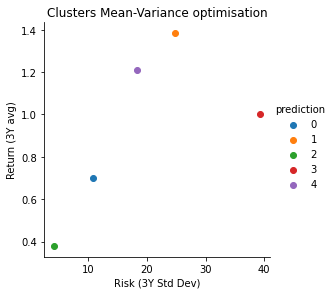

In [89]:
sns.FacetGrid(plot1_df,hue="prediction", height=4).map(plt.scatter,'avg(fund_stdev_3years)', 'avg(fund_mean_annual_return_3years)').add_legend()
plt.ylabel('Return (3Y avg)')
plt.xlabel('Risk (3Y Std Dev)')
plt.title('Clusters Mean-Variance optimisation')
plt.show()

Clusters 1 & 4 provide the best risk-adjusted return compared to other clusters with respectively 139% / 121% 3Y return and 24.9 / 18.3 standard deviation. Cluster 3 is the least efficient cluster, it has a lower 3Y average return than clusters 1 and 4 while carrying more volatility.

In [90]:
for i in range(0,5):
    final_model_k.filter(final_model_k.prediction == i).groupBy('fund_category').count().sort(col('count').desc()).show(10, truncate=False)

+-----------------------------+-----+
|fund_category                |count|
+-----------------------------+-----+
|High Yield Bond              |550  |
|Allocation--50% to 70% Equity|549  |
|Allocation--30% to 50% Equity|409  |
|World Allocation             |306  |
|Emerging Markets Bond        |217  |
|Target-Date 2030             |191  |
|Target-Date 2025             |187  |
|Bank Loan                    |180  |
|Tactical Allocation          |152  |
|Target-Date 2020             |144  |
+-----------------------------+-----+
only showing top 10 rows

+-------------------------+-----+
|fund_category            |count|
+-------------------------+-----+
|Small Blend              |547  |
|Small Growth             |514  |
|Small Value              |333  |
|Mid-Cap Growth           |326  |
|Mid-Cap Value            |307  |
|Large Value              |258  |
|Mid-Cap Blend            |211  |
|Large Growth             |176  |
|Diversified Emerging Mkts|90   |
|Technology               |89   |


In [91]:
final_model_k.filter(final_model_k.prediction == 4).groupBy('fund_category').count().sort(col('count').desc()).show(10, truncate=False)

+-------------------------+-----+
|fund_category            |count|
+-------------------------+-----+
|Large Blend              |1071 |
|Large Growth             |928  |
|Large Value              |751  |
|Foreign Large Blend      |595  |
|Diversified Emerging Mkts|572  |
|Foreign Large Growth     |354  |
|World Large-Stock Blend  |245  |
|Foreign Large Value      |193  |
|Target-Date 2050         |191  |
|Target-Date 2055         |189  |
+-------------------------+-----+
only showing top 10 rows



In [92]:
final_model_k.filter(final_model_k.prediction == 1).groupBy('fund_category').count().sort(col('count').desc()).show(10, truncate=False)

+-------------------------+-----+
|fund_category            |count|
+-------------------------+-----+
|Small Blend              |547  |
|Small Growth             |514  |
|Small Value              |333  |
|Mid-Cap Growth           |326  |
|Mid-Cap Value            |307  |
|Large Value              |258  |
|Mid-Cap Blend            |211  |
|Large Growth             |176  |
|Diversified Emerging Mkts|90   |
|Technology               |89   |
+-------------------------+-----+
only showing top 10 rows



Cluster 4 comprises domestic (U.S.) Large Cap funds of various styles (Blend, Growth, Value), as well as non-U.S. Large Cap funds (Foreign Large Blend, World Large-Stock Blend). In contrast, Cluster 1 is more heavily focused on small and mid-cap funds of all styles, with some Large Value/Growth and Technology funds included as well.

Although these clusters do provide the best performing funds among broad categories such as Large or Small Blend, they still consist of 3529 and 7944 funds, respectively, which can be overwhelming for the retail investor. Furthermore, the two simple metrics we have employed here do not take into account the primary drawback of active mutual funds: do they actually outperform the market?

#### Attempt 2

For our next attempt, we aim to identify a more selective cluster that narrows down the recommended funds even further. To achieve this, we plan to increase the number of features and clusters. Additionally, we aim to ensure that the cluster is comprised of funds that generate excess returns.

To achieve this goal, we will be utilizing all 20 performance metrics saved in the FUND_PERF_METRIC dataset, including metrics such as alpha, beta, and Treynor ratio. However, we acknowledge that there is a clear issue of data redundancy here, as all these parameters are interrelated. For instance, the 10-year return includes the 3-year return, while the Treynor ratio comprises the portfolio return and beta.

To overcome this challenge, we will be utilizing Principal Component Analysis (PCA), which is a widely used dimensionality reduction technique employed in unsupervised learning algorithms. By transforming the dataset into a reduced set of uncorrelated variables (or Principal Components), PCA ensures that the maximum variation in the dataset is retained, while also minimizing the loss of information.

Moreover, PCA can be used to visualize the results from K-Means on a high-dimensional dataset.

In [240]:
from pyspark.ml.feature import PCA as pc

In [241]:
attempt2_df = dataset.select(['fund_symbol','fund_category',*FUND_PERF_METRICS,*FUND_COST]).dropna()

In [242]:
# create features vector
features_column2 = [*FUND_PERF_METRICS]
assembler2 = VectorAssembler(inputCols=features_column2, outputCol='features2')
data_assembled2 = assembler2.transform(attempt2_df)

# Normalize the data
scaler2 = StandardScaler(inputCol='features2',outputCol='scaledFeatures2')
scaler2_fit = scaler2.fit(data_assembled2)
model2_scaled= scaler2_fit.transform(data_assembled2)

In [249]:
# Apply Kmean, fit the model
kmeans2 = KMeans(featuresCol='scaledFeatures2',k=5, seed=1)
model2_fit = kmeans2.fit(model2_scaled)
model2_final = model2_fit.transform(model2_scaled)

# show the clusters
model2_final.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1885|
|         3| 2455|
|         4|    4|
|         2| 4829|
|         0| 3784|
+----------+-----+



In [250]:
# Evaluating the model
cluster_silhouette2 = {}
silhouette2 = ClusteringEvaluator(featuresCol='scaledFeatures2').evaluate(model2_final)
print("Silhouette with squared euclidean distance = " + str(silhouette2))

# list the silhouette for each k
if silhouette2 not in cluster_silhouette2:
    cluster_silhouette2.update({model2_final.select('prediction').distinct().count():silhouette2})

Silhouette with squared euclidean distance = 0.4189996575132949


PCA creates a new set of features consisting of a linear combination of all the input features

In [251]:
pca = pc(k=20, inputCol='scaledFeatures2', outputCol="pca_features2")
pca_fit = pca.fit(model2_scaled)

In [252]:
len(features_column2)

20

In [253]:
pca_fit.explainedVariance.cumsum()

array([0.39060992, 0.62327995, 0.76779834, 0.84115942, 0.88491346,
       0.92791416, 0.95026087, 0.96859579, 0.97889113, 0.98783964,
       0.99177227, 0.99431618, 0.99649659, 0.99794351, 0.99901568,
       0.99943341, 0.99972515, 0.9998921 , 0.99997396, 1.        ])

PCA shows that 84% of variation in the dataset is explained by the first 4 variables. We set our threshold at 80%, therefore we should only keep our first 4 paremeters here namely: 
- fund_alpha_3years,
- fund_beta_3years,
- fund_mean_annual_return_3years,
- fund_r_squared_3years,

In [254]:
PCA_params = ['fund_alpha_3years','fund_beta_3years','fund_mean_annual_return_3years','fund_r_squared_3years']

In [260]:
# create features vector
features_column2 = [*PCA_params]
assembler2 = VectorAssembler(inputCols=features_column2, outputCol='features2')
data_assembled2 = assembler2.transform(attempt2_df)

# Normalize the data
scaler2 = StandardScaler(inputCol='features2',outputCol='scaledFeatures2')
scaler2_fit = scaler2.fit(data_assembled2)
model2_scaled= scaler2_fit.transform(data_assembled2)

In [277]:
# Apply Kmean, fit the model
kmeans2 = KMeans(featuresCol='scaledFeatures2',k=21, seed=1)
model2_fit = kmeans2.fit(model2_scaled)
model2_final = model2_fit.transform(model2_scaled)

# show the clusters
model2_final.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|        12|  796|
|         1|  895|
|        13|  877|
|         6|    6|
|        16|   47|
|         3|  942|
|        20|  600|
|         5|  873|
|        19|  958|
|        15|   19|
|        17|  297|
|         9|   12|
|         4| 1354|
|         8|   44|
|         7|  701|
|        10|  289|
|        11| 1916|
|        14|  906|
|         2|  347|
|         0|   89|
+----------+-----+
only showing top 20 rows



In [280]:
cluster_silhouette3 = {}
silhouette3 = ClusteringEvaluator(featuresCol='scaledFeatures2').evaluate(model2_final)
print("Silhouette with squared euclidean distance = " + str(silhouette3))

# # list the silhouette for each k
# if silhouette2 not in cluster_silhouette2:
#     cluster_silhouette2.update({model2_final.select('prediction').distinct().count():silhouette2})

Silhouette with squared euclidean distance = 0.4885008851156839


In [281]:
plot2_df = model2_final.groupBy('prediction').agg(F.avg(F.col('fund_alpha_3years')),
                                                  F.avg(F.col('fund_beta_3years')),
                                                  F.avg(F.col('fund_mean_annual_return_3years')),
                                                  F.avg(F.col('fund_r_squared_3years'))
                                                 ).toPandas()
plot2_df.set_index('prediction').sort_index(ascending=True)

,avg(fund_alpha_3years),avg(fund_beta_3years),avg(fund_mean_annual_return_3years),avg(fund_r_squared_3years)
prediction,,,,
0,9.172921,0.736966,1.661910,34.627416
1,-0.142101,0.526615,0.395508,80.858447
2,-14.727291,1.478617,0.927176,78.917579
3,-4.409671,1.039565,1.241592,91.754660
4,-0.573700,1.031883,0.392821,93.286137
5,0.681031,0.265372,0.255338,15.931042
6,3.496667,-3.733333,-0.485000,40.803333
7,0.090528,1.060399,0.491141,54.267475
8,-4.801364,3.344545,0.763182,70.014318


In [282]:
# optimal cluster
model2_final.filter(model2_final.prediction == 0).groupBy('fund_category').count().sort(col('count').desc()).show(truncate=False)

+-------------------------+-----+
|fund_category            |count|
+-------------------------+-----+
|Equity Precious Metals   |44   |
|Health                   |12   |
|China Region             |11   |
|Tactical Allocation      |8    |
|Relative Value Arbitrage |3    |
|Utilities                |3    |
|Diversified Emerging Mkts|2    |
|Long-Short Equity        |2    |
|World Small/Mid Stock    |2    |
|Pacific/Asia ex-Japan Stk|2    |
+-------------------------+-----+



An interesting observation from our analysis is that there are no Technology funds within the cluster of funds generating excess returns. This could potentially indicate that taking a risk-adjusted approach, it may not be worth relying on active technology funds and instead focus on tracking the index. In contrast, our analysis reveals that there is significant value added by investing in active mutual funds that specialize in Equity Precious Metals, Health, and China.

However, it is important to note that both Equity Precious Metals and China Region were also among the highest-ranked fund categories when we filtered based on Morningstar Ratings. Therefore, it appears that these categories may be a reliable source for identifying funds that can potentially generate excess returns.

In [283]:
# second best cluster
model2_final.filter(model2_final.prediction == 10).groupBy('fund_category').count().sort(col('count').desc()).show(truncate=False)

+-------------------------+-----+
|fund_category            |count|
+-------------------------+-----+
|Large Growth             |116  |
|Convertibles             |43   |
|Diversified Emerging Mkts|35   |
|Technology               |34   |
|Foreign Large Growth     |12   |
|Mid-Cap Growth           |9    |
|Large Blend              |6    |
|Mid-Cap Blend            |5    |
|Foreign Small/Mid Growth |4    |
|Small Growth             |4    |
|World Small/Mid Stock    |3    |
|Consumer Cyclical        |3    |
|Miscellaneous Region     |3    |
|Communications           |2    |
|Real Estate              |2    |
|Diversified Pacific/Asia |2    |
|World Large-Stock Blend  |2    |
|Allocation--85%+ Equity  |1    |
|Financial                |1    |
|Equity Precious Metals   |1    |
+-------------------------+-----+
only showing top 20 rows



In [284]:
# pca can be used for visualising K-Means through dimensionality reduction to two
pca = pc(k=2, inputCol='scaledFeatures2', outputCol="pca_features2")
pca_fit = pca.fit(model2_scaled)
pca_final_model = pca_fit.transform(model2_scaled)

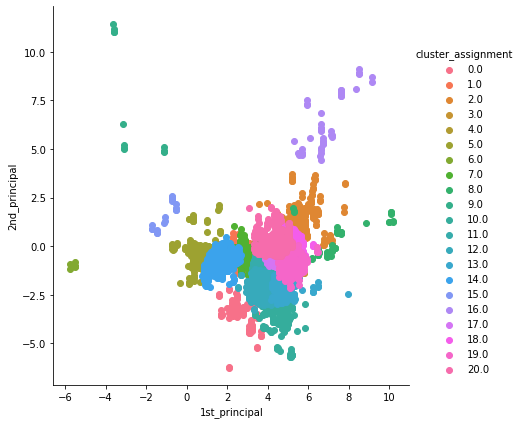

In [285]:
# save the pca transformed dataset in a numpy array, apply a lambda function through rdd map() method to extract the principal components
array_pca= np.array(pca_final_model.rdd.map(lambda row: row.pca_features2).collect())

# do the same for predictions and reshape the single feature array
assigned_clusters = np.array(model2_final.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

# stack the two arrays horizontally
pca_data = np.hstack((array_pca,assigned_clusters))

# convert to a dataframe, generate a seborn grid object then plot the data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","clusters"))
sns.FacetGrid(pca_df,hue="clusters", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()

## Conclusion

In this coursework, we have demonstrated the application of machine learning techniques to large datasets for investment decision-making. Although our dataset was relatively small compared to Big Data standards, we believe that our approach can be scaled to larger datasets by applying the same constraints specific to distributed computing.

Our primary objective was to identify a cluster of the best-performing mutual funds based on a combination of performance metrics, rather than their traditional investment objectives or classifications. Our first run of the K-Means algorithm led us to identify two clusters that were more efficient than the others. However, we found that the mean-variance optimization approach, as taught in the Modern Portfolio Theory, was not enough to consider the excess return over the benchmark.

To overcome this limitation, we used more features in our K-Means algorithm to confirm that most active mutual funds underperform the market, as the average alpha generated was negative. Our clustering approach effectively narrowed down the vast selection of mutual funds to a diversified cluster that would be more manageable for retail investors.

The main limitation of our approach is that past performance is not necessarily indicative of future results. Our clustering approach provided interesting categories to explore further, such as Equity Precious Metals, Health, and China Region, which had the best risk-adjusted excess return in recent years. However, mean reversion is common in financial markets, and further analysis and insights from the future will be necessary to make definitive investment decisions.

Overall, our approach demonstrated the potential of machine learning in investment decision-making, highlighting the importance of a data-driven approach to navigate the vast selection of mutual funds and make informed investment decisions.

### References

**Academic Papers:**

Convergence Properties of the K-Means Algorithm, Léon Bottou & Yoshua Bengio,  Neuristique S.A/Université de Montréal
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.50.3258&rep=rep1&type=pdf

Don’t Take Their Word for It: The Misclassification of Bond Mutual Funds, Achla Marathe & Hany A. Shawky, National Bureau of Economic Research, November 2019.
https://www.nber.org/system/files/working_papers/w26423/w26423.pdf


**Online articles:**

A large chunk of the retail investing crowd started during the pandemic, Schwab survey shows, Maggie Fitzgerald, CNBC
https://www.cnbc.com/2021/04/08/a-large-chunk-of-the-retail-investing-crowd-got-their-start-during-the-pandemic-schwab-survey-shows.html

French regulator AMF asks H2O to suspend funds, Robert Smith, Financial Times, August 2020
https://www.ft.com/content/0371b51a-21c7-40e6-82b8-a3799fd96cb6

Is Bond Fund Misclassification a Serious Problem?, Ed McCarthy, Plan Adviser, September 2021
https://www.planadviser.com/exclusives/bond-fund-misclassification-serious-problem/

https://www.data4v.com/tutorial-k-means-clustering-on-spark/![image.png](attachment:image.png)

How to Load Kaggle Datasets Directly into Google Colab?, Kaustubh Gupta, analyticsvidhya, June 2021
https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

Principal Component Analysis and k-means Clustering to Visualize a High Dimensional Dataset, Dmitriy, Medium, February 2019
https://medium.com/more-python-less-problems/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2

Finding Mutual Funds most informative characteristics using Machine Learning, Bernard Kurka, Medium, February 2019
https://medium.com/@bkexcel2014/finding-mutual-funds-most-informative-characteristics-using-machine-learning-7097100c58d1


**Books:**

Data Analysis with Python and PySpark, Jonathan Rioux, 2022

**Online Courses:**

Spark and Python for Big Data with PySpark, Jose Portilla, Pieran Data, 2019

### Word Count

In [ ]:
%%js

// Run this cell to update your word count.

function wordcount() {
    let wordCount = 0
    let extraCount = 0
    let mainBody = true

    let cells = Jupyter.notebook.get_cells()
    cells.forEach((cell) => {
        if (cell.cell_type == 'markdown') {
            let text = cell.get_text()
            // Stop counting as main body when get to References or Appendices.
            if (text.startsWith('## References') ||
                text.startsWith('## Appendices')) {
                mainBody = false
            }
            if (text.startsWith('## Word Count')) {
                text = ''
            }
            if (text) {
                let words = text.toLowerCase().match(/\b[a-z\d]+\b/g)
                if (words) {
                    let cellCount = words.length
                    if (mainBody) {
                        wordCount += cellCount
                    } else {
                        extraCount += cellCount
                    }
                }
            }
        }
    })
    return [wordCount, extraCount]
}

let wc = wordcount()
element.append(`Main word count: ${wc[0]} (References and appendices word count: ${wc[1]})`)